<a href="https://colab.research.google.com/github/indrajeetapache/kaggle-solutions/blob/main/Regression_of_Used_Car_Prices/Regression_of_Used_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle

Mounted at /content/drive


In [ ]:
!mkdir -p ~/kaggle/input/Regression
!ls -l ~/kaggle/input

total 4
drwxr-xr-x 2 root root 4096 Sep 16 05:44 Regression


In [ ]:
!cp /content/drive/MyDrive/kaggle_account/kaggle.json ~/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s4e9 -p ~/kaggle/input/Regression



 89% 7.00M/7.84M [00:01<00:00, 10.8MB/s]
100% 7.84M/7.84M [00:01<00:00, 7.43MB/s]


In [ ]:
#Unzipping the data
!ls ~/kaggle/input/Regression
!unzip -o ~/kaggle/input/Regression/*.zip -d ~/kaggle/input/Regression > /dev/null 2>&1

playground-series-s4e9.zip


In [ ]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization libraries (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Data preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



In [ ]:
# Load the data from the specified directory
train_path = '/root/kaggle/input/Regression/train.csv'
test_path = '/root/kaggle/input/Regression/test.csv'

# Load the train and test datasets
train_data= pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [ ]:
train_data.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


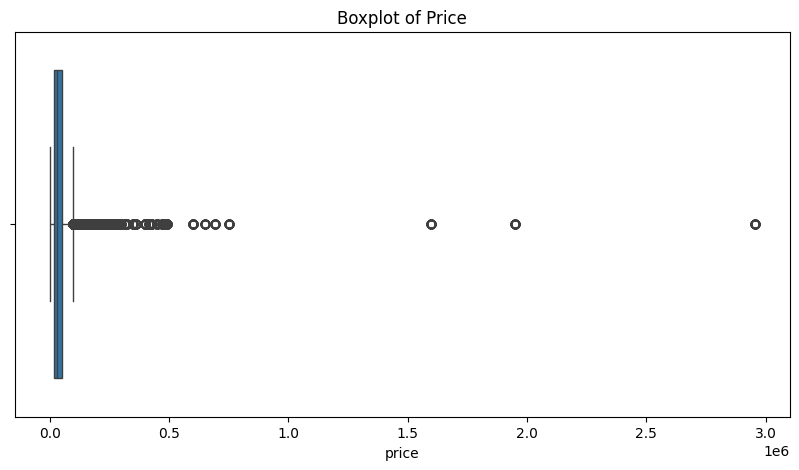

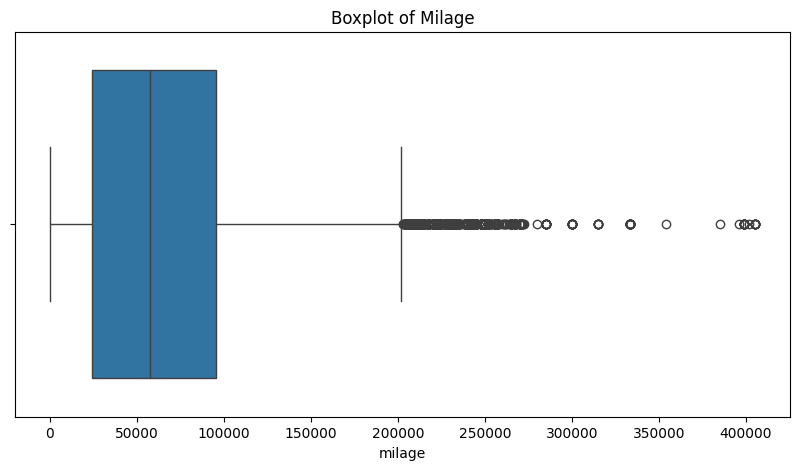

Z-scores:            price    milage
0       0.503405  2.957842
1       0.493268  1.557184
2       0.380338  1.426276
3       0.014235  0.927854
4       0.680315  1.171076
...          ...       ...
188528  0.207792  0.335461
188529  0.176074  0.745116
188530  0.545830  1.045328
188531  0.520456  1.040409
188532  0.188824  0.124609

[188533 rows x 2 columns]


In [ ]:
# Visualize outliers using boxplots
plt.figure(figsize=(10,5))
sns.boxplot(x=train_data['price'])
plt.title("Boxplot of Price")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=train_data['milage'])
plt.title("Boxplot of Milage")
plt.show()

# Z-score for price to detect outliers
z_scores = np.abs(stats.zscore(train_data[['price', 'milage']]))
print(f"Z-scores: {z_scores}")

In [ ]:
# # Cap the top 1% and bottom 1% of price and milage
# def cap_outliers(series):
#     lower_cap = series.quantile(0.01)
#     upper_cap = series.quantile(0.99)
#     return series.clip(lower=lower_cap, upper=upper_cap)

# train_data['price'] = cap_outliers(train_data['price'])
# train_data['milage'] = cap_outliers(train_data['milage'])


In [ ]:
imputer_cat = SimpleImputer(strategy='most_frequent')
categorical_cols = ['fuel_type', 'accident', 'clean_title']
train_data[categorical_cols] = imputer_cat.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = imputer_cat.transform(test_data[categorical_cols])

# For numerical columns, we can use median to fill NaNs
imputer_num = SimpleImputer(strategy='median')
numerical_cols = ['milage']
train_data[numerical_cols] = imputer_num.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = imputer_num.transform(test_data[numerical_cols])

# Combine the training and testing data to avoid unseen labels issue
combined_data = pd.concat([train_data, test_data], axis=0)

# Specify categorical columns for encoding
# categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'engine']


# One-Hot Encoding for categorical features with unseen categories handling
onehotencoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

In [ ]:
for col in categorical_cols:
    combined_data[col] = combined_data[col].astype(str)

In [ ]:
# One-Hot Encoding for categorical features with unseen categories handling
onehotencoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Apply the One-Hot Encoder to both train and test data
X_combined_encoded = onehotencoder.fit_transform(combined_data)

In [ ]:
combined_data.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000.0,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0
1,1,Lincoln,LS V8,2002,143250.0,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731.0,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500.0,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0
4,4,Mercedes-Benz,Metris Base,2021,7388.0,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0
5,5,Audi,A6 2.0T Sport,2018,40950.0,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950.0
6,6,Audi,A8 L 3.0T,2016,62200.0,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500.0
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604.0,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500.0
8,8,Ford,F-150 XLT,2020,38352.0,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890.0
9,9,BMW,M4 Base,2015,74850.0,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000.0


In [ ]:
X_train_encoded = X_combined_encoded[:len(train_data)]
X_test_encoded = X_combined_encoded[len(train_data):]
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(188533, 3614)
(125690, 3614)


In [ ]:
# Apply the One-Hot Encoder to both train and test data
X_combined_encoded = onehotencoder.fit_transform(combined_data)

# Split back into training and testing sets
X_train_encoded = X_combined_encoded[:len(train_data)]
X_test_encoded = X_combined_encoded[len(train_data):]

# Separate the target variable
y = train_data['price']

# Now you can proceed with model training
# Train-test split for model validation (optional)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

# # Build and train the XGBoost model
# from xgboost import XGBRegressor
# xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
# xgb.fit(X_train, y_train)

# # Predict and evaluate on the validation set
# from sklearn.metrics import mean_squared_error
# y_pred = xgb.predict(X_val)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Validation RMSE: {rmse}")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor


In [ ]:
# Number of folds for K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Prepare for collecting results
rmse_list = []

# Loop through each fold
for train_index, val_index in kf.split(X_train_encoded):
    X_train_fold, X_val_fold = X_train_encoded[train_index], X_train_encoded[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Train the model on the current fold
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42)
    xgb.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_val_pred = xgb.predict(X_val_fold)

    # Compute RMSE for the current fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmse_list.append(rmse_fold)
    print(f"Fold RMSE: {rmse_fold}")

# Calculate and print the average RMSE across all folds
average_rmse = np.mean(rmse_list)
print(f"Average K-Fold RMSE: {average_rmse}")

Fold RMSE: 1047.074255422296
Fold RMSE: 1007.7483097782721
Fold RMSE: 991.2800009337687
Fold RMSE: 1047.0611873245916
Fold RMSE: 991.8996534773999
Average K-Fold RMSE: 1017.0126813872657


In [ ]:
# Retrain the best model on the full training dataset
best_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=3, random_state=42)
best_xgb.fit(X_train_encoded, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
models = [
    XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=42),
    XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42),
    XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
]


# Initialize a dictionary to store results
model_rmse = {}


for model in models:
    rmse_list = []  # To store RMSE values for each fold
    print(f"Evaluating Model: {model}")

    # K-Fold cross-validation
    for train_index, val_index in kf.split(X_train_encoded):
        X_train_fold, X_val_fold = X_train_encoded[train_index], X_train_encoded[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Train the model on the current fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred = model.predict(X_val_fold)

        # Compute RMSE for the current fold
        rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        rmse_list.append(rmse_fold)
        print(f"Fold RMSE: {rmse_fold}")

    # Calculate the average RMSE for this model across all folds
    average_rmse = np.mean(rmse_list)
    model_rmse[str(model)] = average_rmse
    print(f"Average K-Fold RMSE for {model}: {average_rmse}")
    print("="*50)

# Find the model with the lowest average RMSE
best_model = min(model_rmse, key=model_rmse.get)
print(f"Best Model: {best_model}")
print(f"Best Model RMSE: {model_rmse[best_model]}")

Evaluating Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Fold RMSE: 1099.3066802211206
Fold RMSE: 1046.7630476451504
Fold RMSE: 1040.7331939635276
Fold RMSE: 1087.5944331148878
Fold RMSE: 1049.5806054126724
Average K-Fold RMSE for XGBRegressor(base_score=None, booster=None, callbacks=None,
       

**Submission **

In [ ]:
# Retrain the best model on the entire training data
best_xgb.fit(X_train_encoded, y)

# Make predictions on the test set
test_predictions = best_xgb.predict(X_test_encoded)

# Prepare a submission file (for competitions or final output)
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})


In [ ]:
submission

,id,price
0,188533,259350.187500
1,188534,259377.250000
2,188535,259524.750000
3,188536,259138.140625
4,188537,259298.000000
...,...,...
125685,314218,259350.187500
125686,314219,259160.906250
125687,314220,259298.000000
125688,314221,259298.000000


In [ ]:
submission.to_csv('submission.csv', index=False)


In [ ]:
!kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "Regression of Used Car Prices xgboost"


100% 2.02M/2.02M [00:00<00:00, 2.13MB/s]
Successfully submitted to Regression of Used Car Prices

In [ ]:
!kaggle competitions submit -c playground-series-s4e9 -f submission.csv -m "Regression of Used Car Prices xgboost"

100% 2.02M/2.02M [00:00<00:00, 3.25MB/s]
Successfully submitted to Regression of Used Car Prices